## Time Series Forecasting for Portfolio Management Optimization



##### Name: Tadele Bizuye


In [6]:
import warnings
warnings.filterwarnings('ignore')

# --- Imports ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Statsmodels for time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# ML imports for LSTM forecasting
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# For reproducibility of results
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [7]:
# --- Step 0: Configuration ---
START = '2015-07-01'           # Data start date
END = '2025-07-31'             # Data end date
ASSETS = {
    'TSLA': 'TSLA',            # Tesla stock
    'BND' : 'BND',             # Bond ETF
    'SPY' : 'SPY'              # S&P 500 ETF
}

In [8]:
# --- Step 1: Fetch data from Yahoo Finance with safety checks ---
def fetch_data(ticker, start=START, end=END):
    df = yf.download(ticker, start=start, end=end, progress=False)
    df.index = pd.to_datetime(df.index)

    # If columns are MultiIndex, flatten them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    else:
        # Otherwise, replace spaces with underscores
        df.columns = df.columns.str.replace(" ", "_")

    # Create Adj_Close if missing (some assets do not have adjusted prices)
    if "Adj_Close" not in df.columns:
        if "Close" in df.columns:
            df["Adj_Close"] = df["Close"]
        else:
            # Fallback: just pick first column if no 'Close'
            df["Adj_Close"] = df.iloc[:, 0]

    expected_cols = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']
    for col in expected_cols:
        if col not in df.columns:
            df[col] = np.nan

    return df[expected_cols]

print("Fetching data for assets...")
data = {k: fetch_data(v) for k, v in ASSETS.items()}
print("Data fetching complete.")

Fetching data for assets...
Data fetching complete.


In [9]:
# --- Step 2: Align all assets on business day calendar ---
# Create a combined DataFrame with a business day index for the entire date range
combined = pd.DataFrame(index=pd.date_range(start=START, end=END, freq='B'))

# Join each asset's data to the combined DataFrame, forward filling missing prices
for symbol, df in data.items():
    df = df.reindex(combined.index)  # align index with business days
    
    # Forward-fill OHLC and Adj_Close prices to fill weekends/holidays
    df[['Open', 'High', 'Low', 'Close', 'Adj_Close']] = df[['Open', 'High', 'Low', 'Close', 'Adj_Close']].ffill()
    
    # Fill missing Volume with 0 (no trading days)
    df['Volume'] = df['Volume'].fillna(0)
    
    # Rename columns with ticker prefix for clarity
    df.columns = [f"{symbol}_{col}" for col in df.columns]
    
    # Join with combined DataFrame
    combined = combined.join(df)

print("Missing values after fill:", combined.isna().sum().sum())


Missing values after fill: 31584


In [10]:
# --- Step 3: Calculate daily returns and 30-day rolling volatility ---
returns = pd.DataFrame(index=combined.index)

for symbol in ASSETS.keys():
    adj_close_col = f"{symbol}_Adj_Close"
    returns_col = f"{symbol}_ret"
    vol_col = f"{symbol}_vol_30d"
    
    # Daily returns (percentage change)
    returns[returns_col] = combined[adj_close_col].pct_change()
    
    # 30-day rolling volatility (standard deviation of returns annualized)
    returns[vol_col] = returns[returns_col].rolling(window=30).std() * np.sqrt(252)

returns = returns.dropna()

In [11]:
# --- Step 4: Stationarity Testing with Augmented Dickey-Fuller (ADF) test ---
def adf_test(series, title=""):
    """
    Perform ADF test and print results indicating if series is stationary.
    """
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"\nADF Test for {title}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"  Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("  => Series is stationary (reject H0)")
    else:
        print("  => Series is non-stationary (fail to reject H0)")

print("Running stationarity tests...")
adf_test(combined['TSLA_Adj_Close'], "TSLA Adjusted Close")
adf_test(returns['TSLA_ret'], "TSLA Daily Returns")

Running stationarity tests...

ADF Test for TSLA Adjusted Close:
  ADF Statistic: -1.4898
  p-value: 0.5386
  Critical Value 1%: -3.4329
  Critical Value 5%: -2.8626
  Critical Value 10%: -2.5674
  => Series is non-stationary (fail to reject H0)

ADF Test for TSLA Daily Returns:
  ADF Statistic: -15.5619
  p-value: 0.0000
  Critical Value 1%: -3.4329
  Critical Value 5%: -2.8627
  Critical Value 10%: -2.5674
  => Series is stationary (reject H0)


In [12]:
# --- Step 5: Risk metrics calculation (Annualized return, Volatility, Sharpe, VaR) ---
def compute_metrics(series, periods_per_year=252):
    mean = series.mean() * periods_per_year
    vol = series.std() * np.sqrt(periods_per_year)
    sharpe = mean / vol if vol != 0 else np.nan
    var95 = np.percentile(series.dropna(), 5)
    return {'annual_return': mean, 'annual_vol': vol, 'sharpe': sharpe, 'VaR95_daily': var95}

print("\nCalculating risk metrics for each asset:")
metrics = {}
for symbol in ASSETS.keys():
    m = compute_metrics(returns[f"{symbol}_ret"])
    metrics[symbol] = m
    print(f"{symbol}: {m}")


Calculating risk metrics for each asset:
TSLA: {'annual_return': np.float64(0.4595538771984782), 'annual_vol': np.float64(0.5819686026491644), 'sharpe': np.float64(0.7896540725849379), 'VaR95_daily': np.float64(-0.05332834128496927)}
BND: {'annual_return': np.float64(0.01783183162860963), 'annual_vol': np.float64(0.05406356859208977), 'sharpe': np.float64(0.32983082865193375), 'VaR95_daily': np.float64(-0.004824613072768047)}
SPY: {'annual_return': np.float64(0.1404454860586951), 'annual_vol': np.float64(0.17963021008272118), 'sharpe': np.float64(0.7818589422904912), 'VaR95_daily': np.float64(-0.01700659859872439)}


In [13]:
# --- Step 6: Forecasting TSLA with ARIMA (no pmdarima) ---
# Prepare training and testing data
series = combined['TSLA_Adj_Close'].dropna()
train_end_date = pd.to_datetime('2023-12-31')
train = series.loc[:train_end_date]
test = series.loc[train_end_date + pd.Timedelta(days=1):]

# Function to select best ARIMA order via AIC grid search
import itertools
def select_arima_order(series_log, p_max=3, d_max=2, q_max=3):
    best_aic = np.inf
    best_order = None
    for p, d, q in itertools.product(range(p_max+1), range(d_max+1), range(q_max+1)):
        if (p, d, q) == (0, 0, 0):
            continue
        try:
            model = ARIMA(series_log, order=(p, d, q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, d, q)
        except:
            continue
    return best_order, best_aic

print("\nSelecting ARIMA model order by AIC...")
train_log = np.log(train)
order, aic = select_arima_order(train_log)
print(f"Selected ARIMA order: {order} with AIC={aic:.2f}")

# Fit ARIMA model with selected order
arima_model = ARIMA(train_log, order=order).fit()

# Forecast test period
n_test = len(test)
fc_log = arima_model.get_forecast(steps=n_test)
fc_mean = np.exp(fc_log.predicted_mean)  # convert log back to price scale

arima_pred = pd.Series(fc_mean.values, index=test.index[:len(fc_mean)])

# Evaluate ARIMA forecasting error
from sklearn.metrics import mean_squared_error, mean_absolute_error
arima_rmse = np.sqrt(mean_squared_error(test.iloc[:len(arima_pred)], arima_pred))
arima_mae = mean_absolute_error(test.iloc[:len(arima_pred)], arima_pred)

print(f"ARIMA Forecast RMSE on test set: {arima_rmse:.4f}")
print(f"ARIMA Forecast MAE on test set: {arima_mae:.4f}")


Selecting ARIMA model order by AIC...
Selected ARIMA order: (2, 1, 3) with AIC=-8504.71
ARIMA Forecast RMSE on test set: 78.9909
ARIMA Forecast MAE on test set: 63.7418


In [14]:
# --- Step 7: Forecasting TSLA with LSTM ---
# Prepare data scaled between 0 and 1 for LSTM
scaler = MinMaxScaler()
series_values = series.values.reshape(-1, 1)
scaled_series = scaler.fit_transform(series_values)

train_size = len(train)
scaled_train = scaled_series[:train_size]
scaled_test = scaled_series[train_size:]

SEQ_LEN = 60

# Function to create sequences for LSTM input
def create_sequences(data, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train)
# For testing, append last SEQ_LEN of train to scaled_test
combined_test = np.vstack([scaled_train[-SEQ_LEN:], scaled_test])
X_test, y_test = create_sequences(combined_test)

print(f"\nLSTM train data shape: {X_train.shape}, {y_train.shape}")
print(f"LSTM test data shape: {X_test.shape}, {y_test.shape}")

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

print("\nTraining LSTM model...")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Predict on test sequences
lstm_pred_scaled = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).reshape(-1)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(-1)

# Evaluate LSTM predictions
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)

print(f"LSTM Forecast RMSE on test set: {lstm_rmse:.4f}")
print(f"LSTM Forecast MAE on test set: {lstm_mae:.4f}")


LSTM train data shape: (2158, 60, 1), (2158, 1)
LSTM test data shape: (414, 60, 1), (414, 1)

Training LSTM model...
Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0078 - val_loss: 0.0015
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0016 - val_loss: 9.0005e-04
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0015 - val_loss: 9.2983e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0014 - val_loss: 7.5343e-04
Epoch 11/20
61/61 ━

In [15]:
# --- Step 8: Select best model based on RMSE ---
best_model = 'ARIMA' if arima_rmse < lstm_rmse else 'LSTM'
print(f"\nBest model selected based on RMSE: {best_model}")


Best model selected based on RMSE: LSTM


In [16]:
# --- Step 9: Forecast next 6 months (approx 126 business days) ---
forecast_days = 126

if best_model == 'ARIMA':
    full_log_series = np.log(series)
    arima_full = ARIMA(full_log_series, order=order).fit()
    fc_full_log = arima_full.get_forecast(steps=forecast_days)
    fc_full = np.exp(fc_full_log.predicted_mean)
    forecast_index = pd.bdate_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
    forecast_df = pd.DataFrame({'forecast': fc_full.values}, index=forecast_index)
else:
    last_seq = scaled_series[-SEQ_LEN:].reshape(1, SEQ_LEN, 1)
    preds = []
    for _ in range(forecast_days):
        p = model.predict(last_seq)
        preds.append(p.reshape(-1,1))
        last_seq = np.concatenate([last_seq[:,1:,:], p.reshape(1,1,1)], axis=1)
    preds_array = np.vstack(preds)
    preds_inv = scaler.inverse_transform(preds_array).reshape(-1)
    forecast_index = pd.bdate_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
    forecast_df = pd.DataFrame({'forecast': preds_inv}, index=forecast_index)

print("\nForecast preview:")
print(forecast_df.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

In [17]:
# --- Step 10: Portfolio optimization without pypfopt ---
# Expected returns vector: use forecasted TSLA returns and historical BND, SPY returns
tsla_forecast_returns = forecast_df['forecast'].pct_change().dropna()
exp_tsla_return = tsla_forecast_returns.mean() * 252  # annualize

# Historical annualized returns
hist_returns = {k: returns[f"{k}_ret"].mean() * 252 for k in ['BND', 'SPY']}

mu = np.array([exp_tsla_return, hist_returns['BND'], hist_returns['SPY']])

# Covariance matrix of returns annualized
cov_daily = returns[[f"{k}_ret" for k in ASSETS.keys()]].cov()
cov_annual = cov_daily * 252
cov_matrix = cov_annual.loc[[f"{k}_ret" for k in ASSETS.keys()], [f"{k}_ret" for k in ASSETS.keys()]].values

print("\nExpected annual returns vector:")
print(mu)

print("\nAnnual covariance matrix:")
print(cov_matrix)

# Minimum variance portfolio weights calculation
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mu))
w_min_var = inv_cov @ ones / (ones @ inv_cov @ ones)

print("\nMinimum Variance Portfolio weights:")
for sym, w in zip(ASSETS.keys(), w_min_var):
    print(f"  {sym}: {w:.4f}")


Expected annual returns vector:
[-0.84021467  0.01783183  0.14044549]

Annual covariance matrix:
[[0.33868745 0.0018901  0.05128206]
 [0.0018901  0.00292287 0.00114894]
 [0.05128206 0.00114894 0.03226701]]

Minimum Variance Portfolio weights:
  TSLA: -0.0067
  BND: 0.9424
  SPY: 0.0643



Backtest cumulative return for Minimum Variance Portfolio:
2025-07-31    1.03618
Freq: B, dtype: float64


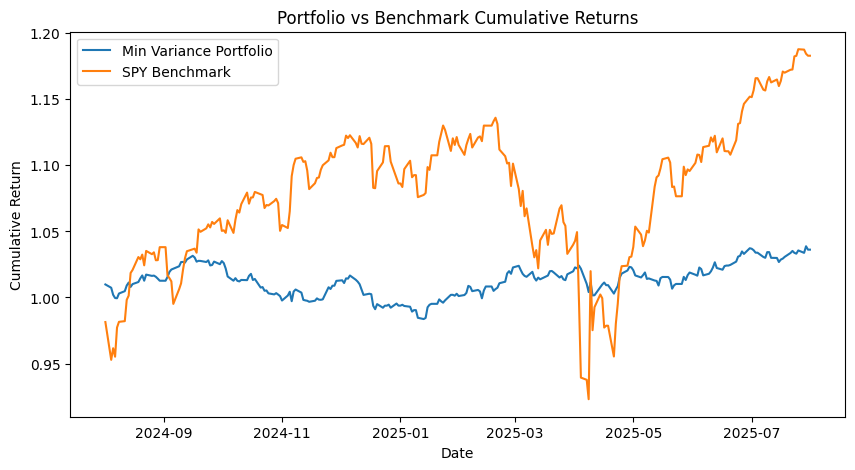

In [18]:
# --- Step 11: Backtesting the portfolio with weights from min variance ---
bt_start = '2024-08-01'
bt_end = '2025-07-31'

price_bt = combined[[f"{k}_Adj_Close" for k in ASSETS.keys()]].loc[bt_start:bt_end].dropna()
price_bt.columns = list(ASSETS.keys())  # rename for convenience

# Daily returns for backtest period
ret_bt = price_bt.pct_change().dropna()

# Portfolio daily returns weighted by min variance portfolio
port_returns = ret_bt @ w_min_var
port_cum_returns = (1 + port_returns).cumprod()

print("\nBacktest cumulative return for Minimum Variance Portfolio:")
print(port_cum_returns.tail(1))

# --- Optional: Plot cumulative returns ---
plt.figure(figsize=(10,5))
plt.plot(port_cum_returns, label="Min Variance Portfolio")
plt.plot((1 + ret_bt['SPY']).cumprod(), label="SPY Benchmark")
plt.title("Portfolio vs Benchmark Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()